In [44]:
import matplotlib.pyplot as plt 
import matplotlib.gridspec as GridSpec
from matplotlib.collections import LineCollection
import matplotlib
import pandas as pd 
import numpy as np 
import os
import shutil

In [45]:
class Measurments():
    # инициализация, проверка существования папки, проверка пустоты папки
    def __init__(self, main_folder: str) -> None:
        if not os.path.exists(main_folder):
            raise FileNotFoundError(f'directory \'{main_folder}\' is not exist')
        elif  (len(os.listdir(main_folder)) == 0):
            raise ValueError(f'directory \'{main_folder}\' is empty')
        else:
            self.main_folder = main_folder
            self.list_of_subdirs = os.listdir(main_folder)
            self.main_file_path = os.path.abspath(main_folder)
            
    # поиск всех вложенных директорий в основной папке
    def _find_contacts_folder(self) -> None:
        self.contacts_list = set()
        for i in self.list_of_subdirs:
            if os.path.isdir('\\'.join([self.main_folder, i])):
                self.contacts_list.add(f'{i}')

    # проверка, что файл типа data
    def _is_data_file(self, path: str) -> bool:
        if path.split('.')[-1] == 'data':
            return True
        else:
            return False
    # создание пути из названия папок
    def _create_path(self, list: list[str]) -> str:
        return '\\'.join([self.main_file_path] + list)

    # считывание данных об измерениях из файлов во вложенных директориях
    def _create_dict_of_measurments(self, return_dict: bool = False) -> None | dict:
        self._find_contacts_folder()
        if len(self.contacts_list) == 0:
            raise ValueError(f'directory \'{self.main_folder}\' does not contain subdirectories')
        self.dict_of_measurments = {}
        for i in self.contacts_list:
            subdir_catalogs_list = [file for file in os.listdir(self._create_path([i])) if self._is_data_file(self._create_path([i, file]))]
            if len(subdir_catalogs_list) == 0:
                continue
            subdir_measurs_type = {}
            for j in subdir_catalogs_list:
                file_path = self._create_path([i, j])
                with open(file_path) as file:
                    measur_type = '_'.join(file.readlines()[1].split()[1:3])
                subdir_measurs_type[j.replace('.data', '')] = measur_type
            self.dict_of_measurments[i] = subdir_measurs_type
        if return_dict == True:
            return self.dict_of_measurments
        
    # возврат словаря с измерениями
    def get_dict_of_measurments(self)-> dict:
        if hasattr(self, 'dict_of_measurments'):
            return self.dict_of_measurments
        else:
            self._create_dict_of_measurments()
            return self.dict_of_measurments
        
    # абсолютный путь к указанной папке
    def get_abspath(self) -> str:
        return self.main_file_path
    
    # получение словаря только с одного контакта
    def get_contact_dict(self, contact_name: str | int) -> dict:
        if not isinstance(contact_name, str | int):
            raise ValueError(f'contact_name must be str or int type')
        elif not hasattr(self, 'dict_of_measurments'):
            self._create_dict_of_measurments()
        elif str(contact_name) not in list(self.dict_of_measurments.keys()):
            raise ValueError(f'{contact_name} not exist in {self.main_folder}')
        return {str(contact_name) :self.dict_of_measurments[str(contact_name)]}
    
    # удаление папки или папок
    def delete_contacts(self, contact_name: str | list, return_dict: bool = False) -> dict | None:
        if not hasattr(self, 'dict_of_measurments'):
            self._create_dict_of_measurments()
        contact_from_dict = list(self.dict_of_measurments.keys())
        existed_contact = []
        # проверка типов и существования
        if not isinstance(contact_name, list):
            contact_name = [contact_name]
        for i in contact_name:
            if not isinstance(i, str):
                try:
                    i = str(i)
                except:
                    raise TypeError(f'{i} is not {str} or can\'t be converted to {str}')
            if i in contact_from_dict:
                existed_contact.append(i)
        for i in existed_contact:
            del self.dict_of_measurments[i]
        if return_dict == True:
            return self.dict_of_measurments
    
    # удаление измерений из контакта 
    def delete_measurments(self, del_dict: dict) -> None:
        if not hasattr(self, 'dict_of_measurments'):
            self._create_dict_of_measurments()
        del_dict_keys = list(del_dict.keys())
        all_dict_keys = list(self.dict_of_measurments.keys())
        for contact in del_dict_keys:
            if str(contact) in all_dict_keys:
                if not isinstance(del_dict[contact], list):
                    raise ValueError(f'dict values must be {list} type')
                for measur in del_dict[contact]:
                    if str(measur) in list(self.dict_of_measurments[str(contact)]):
                        self.dict_of_measurments[str(contact)].pop(str(measur), None)
                    else:
                        continue

            else:
                continue

In [46]:
class Prosses_DC_IV():
     
    def __init__(self, sample_path: str) -> None:
        self.sample_path = sample_path
        
    def get_single_data(self, contact: str, measure: str) -> pd.DataFrame:
        measure_dir = self.sample_path + '\\' + str(contact) + '\\' + str(measure) + '.data'
        dataframe = pd.read_csv(measure_dir, delimiter='   ', skiprows=16, engine='python', header=None, encoding='ISO-8859-1').astype(np.float32)
        dataframe.rename(columns = {0: 'voltage', 1: 'current', 2: 'resistance'}, inplace=True)
        dataframe['voltage'] = pd.Series([round(i, 2) for i in dataframe['voltage']])
        return dataframe

    def get_on_off_current(self, dict_of_measurs: dict, check_voltage: float)-> dict:
        I_on = []
        I_off = []
        I_on_off = []

        for folder in list(dict_of_measurs.keys()):
            for measur in list(dict_of_measurs[folder].keys()):
                if dict_of_measurs[folder][measur] == 'DC_IV':
                    DC_IV_data = self.get_single_data(folder, measur)
                else:
                    continue
                if check_voltage not in list(DC_IV_data['voltage']):
                    print(f'value V = {check_voltage} is not exist in file \'{measur}.data\' from \'{folder}\' folder')
                    continue
                else:
                    try:
                        a, b = DC_IV_data.loc[DC_IV_data['voltage'] == check_voltage]['current']
                        I_on.append(a)
                        I_off.append(b)
                        I_on_off.append(a/b)
                    except:
                        print(f'Unexpected error in file \'{measur}.data\' from \'{folder}\' folder')
                        continue
        return {'I_on': I_on, 'I_off': I_off, 'I_on_off': I_on_off}

    def get_on_off_voltage(self):
        pass

    def get_data_from_custom_dict(self):
        pass


(array([36., 15., 12.,  7.,  5.,  3.,  5.,  3.,  5.,  1.,  0.,  2.,  1.,
         0.,  1.]),
 array([1.50000005e-06, 2.37346673e-06, 3.24693340e-06, 4.12040008e-06,
        4.99386676e-06, 5.86733343e-06, 6.74080011e-06, 7.61426678e-06,
        8.48773346e-06, 9.36120014e-06, 1.02346668e-05, 1.11081335e-05,
        1.19816002e-05, 1.28550668e-05, 1.37285335e-05, 1.46020002e-05]),
 <BarContainer object of 15 artists>)

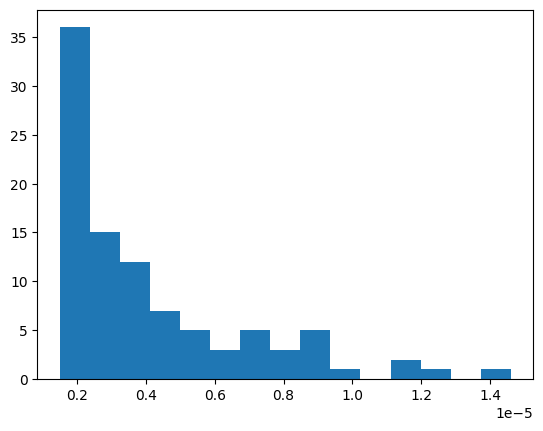

In [47]:
m = Measurments('hBN_1')
m.delete_measurments({16: list(range(1,53)) + list(range(100, 106)) + [155]})
dict_16 = m.get_contact_dict(16)
p = Prosses_DC_IV(m.get_abspath())
I_data = p.get_on_off_current(dict_16, 1)
plt.hist(I_data['I_off'], bins=15)